In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
from google.cloud import storage
from io import BytesIO
from sklearn.decomposition import PCA
from skimage.transform import resize

In [42]:
# Function to download all files from a GCS bucket folder to a local directory
def download_folder_from_gcs(bucket_name, prefix, local_dir):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)

    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    for blob in blobs:
        # Create the local file path
        local_file_path = os.path.join(local_dir, os.path.basename(blob.name))
        # Download the blob to the local file
        blob.download_to_filename(local_file_path)

# Function to load NIfTI images from a local directory and extract embedding vectors
def load_images_from_local_dir(local_dir, target_shape=(64, 64, 64)):  # Specify target shape
    embeddings = []
    for filename in os.listdir(local_dir):
        if filename.endswith('.nii.gz'):
            file_path = os.path.join(local_dir, filename)
            img = nib.load(file_path)
            img_data = img.get_fdata()

            # Resize the image to the target shape
            img_data_resized = resize(img_data, target_shape, mode='reflect')

            # Flatten the resized image data
            embedding_vector = img_data_resized.flatten()
            embeddings.append(embedding_vector)
    
    return np.array(embeddings)

# Specify your GCS bucket name and prefix (folder path)
bucket_name = 'marketplace-2xim6sjc'  # Your bucket name
prefix = 'Medical Decathlon Heart/146/artifactFiles/imagesTr/'  # Your folder path inside the bucket
local_dir = 'downloaded_images'  # Local directory to save the downloaded images


In [38]:
# Download the folder from GCS
download_folder_from_gcs(bucket_name, prefix, local_dir)

'downloaded_images'

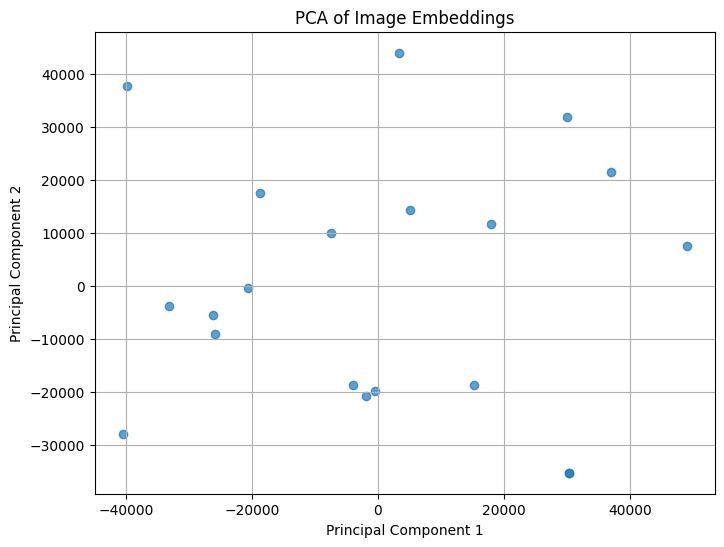

In [43]:

# Load images and get embeddings from the local directory
embeddings = load_images_from_local_dir(local_dir)

# Check if embeddings are loaded
if embeddings.size == 0:
    print("No embeddings found. Please check your bucket and prefix.")
else:
    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    # Visualize the results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title('PCA of Image Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()